In [36]:
import sys
sys.path.append('../')

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

DATA_PATH = "/dust3r/masked_dust3r/data/jackal_training_data_0"

with open(os.path.join(DATA_PATH, "transforms.json"), "r") as f:
    transforms = json.load(f)

[[  33.8696986    -1.31202088 -149.0888628 ]
 [  33.88669054   -1.25529607 -158.18901991]
 [  33.84840785   -1.23697342 -161.76067663]
 [  33.88560532   -1.26102029 -164.7014852 ]
 [  33.88804162   -1.25157864  174.74913276]
 [  33.88092647   -1.28622073  159.80335378]
 [  33.84308096   -1.27212011  163.60220977]
 [  33.86047331   -1.28781925  160.39533765]
 [  33.86049078   -1.23625543  156.21267249]
 [  33.83268128   -1.2481092   149.83886997]
 [  33.83207034   -1.2542924   145.26340577]
 [  33.88751898   -1.248284    141.80670036]
 [  33.88587923   -1.24875539  119.21100213]
 [  33.85219942   -1.24355354   93.33313065]
 [  33.83296873   -1.23664243   83.93472582]
 [  33.88463018   -1.24650932   77.51842412]
 [  33.87533781   -1.25238994   72.10804231]
 [  33.83872433   -1.27529126   66.67300479]
 [  33.88071669   -1.27380156   67.56360771]
 [  33.85697087   -1.29016406   68.47055039]
 [  33.87641542   -1.30841336   62.94664016]
 [  33.88778895   -1.23982217   58.39955045]
 [  33.846

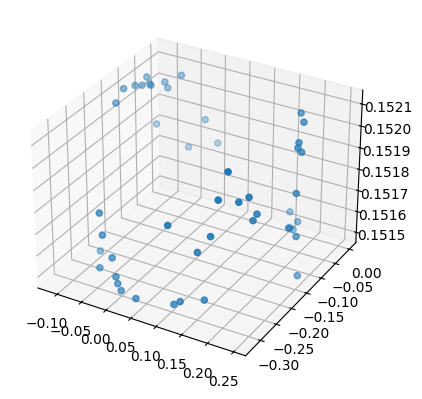

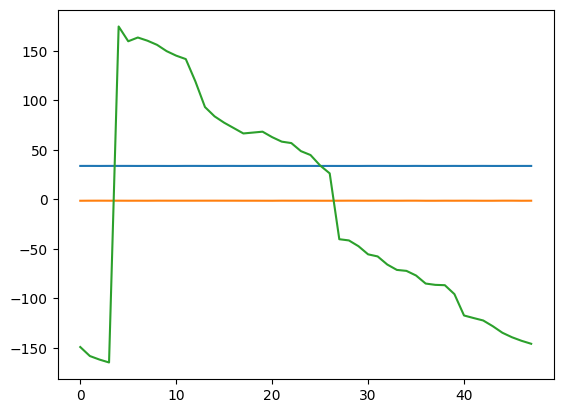

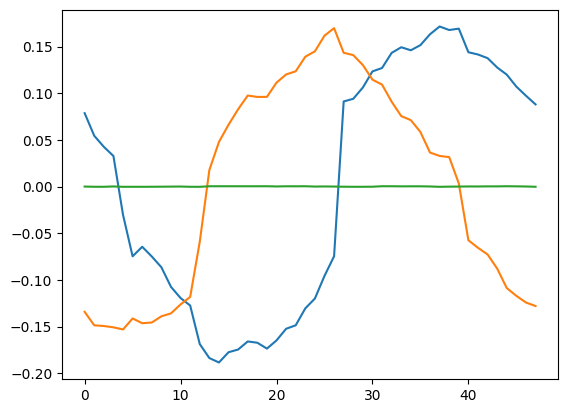

In [37]:
#transforms["frames"] = rotate_best_fit_plane(transforms["frames"])

points = []
euler_angle = []
for frame in transforms["frames"]:
    tf = frame["transform_matrix"]
    tf = np.array(tf).reshape(4, 4)
    points.append(tf[0:3, 3])
    r = R.from_matrix(tf[0:3, 0:3])
    euler_angle.append(r.as_euler('xyz', degrees=True))

points = np.array(points)
euler_angle = np.array(euler_angle)
print(euler_angle)

# Plot the points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])

# Plot the euler angles with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(euler_angle[:, 0], label="x")
ax.plot(euler_angle[:, 1], label="y")
ax.plot(euler_angle[:, 2], label="z")

# Plot the points with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(points[:, 0] - points[:,0].sum()/len(points[:,0]), label="x")
ax.plot(points[:, 1] - points[:,1].sum()/len(points[:,1]), label="y")
ax.plot(points[:, 2] - points[:,2].sum()/len(points[:,2]), label="z")

plt.show()